<a href="https://colab.research.google.com/github/Avelez164/CPSC481-Project/blob/main/brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###1. Import dataset from Kaggle#

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


Copy dataset from read-only location to writable working dir

In [2]:
import shutil
shutil.copytree('/kaggle/input/brain-tumor-mri-dataset', '/kaggle/working/brain-tumor-mri-dataset')


'/kaggle/working/brain-tumor-mri-dataset'

##2. Image Pre-processing

###2.1 checking and removing duplicates

In [3]:
import os
PROJECT_DIR = "/kaggle/working/brain-tumor-mri-dataset"

# Folder names used as labels
LABELS = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [4]:
import hashlib

def compute_hash(file):
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()


def list_files(hash_dict):
    for data_type in ['Training', 'Testing']:
        for label in LABELS:
            folder_path = os.path.join(PROJECT_DIR, data_type, label)
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".jpg"):
                        file_path = os.path.join(root, file)
                        file_hash = compute_hash(file_path)
                        if file_hash in hash_dict:
                            hash_dict[file_hash].append(file_path)
                        else:
                            hash_dict[file_hash] = [file_path]


def remove_duplicates(hash_dict):
    duplicate_count = 0
    for hash_value, file_paths in hash_dict.items():
        if len(file_paths) > 1:
            for file_path in file_paths[1:]:
                print(f"Removing duplicate (hash : {hash_value}) : {file_path}")
                os.remove(file_path)
                duplicate_count += 1
    print(f"Number of duplicates : {duplicate_count}")


if __name__ == '__main__':
    hash_dict = {}
    list_files(hash_dict)
    remove_duplicates(hash_dict)


Removing duplicate (hash : ab525628d00898aa6b1088d9c1d5a785) : /kaggle/working/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0175.jpg
Removing duplicate (hash : a501e6ea3748d3aebea8e8735268ec5b) : /kaggle/working/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0238.jpg
Removing duplicate (hash : 832c3e0243e8fafe4313d899e233285d) : /kaggle/working/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0616.jpg
Removing duplicate (hash : 333ca271271562e025951545e76a8b0b) : /kaggle/working/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0251.jpg
Removing duplicate (hash : 3cb1d6594ea1a7391608e9bc8245529c) : /kaggle/working/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0143.jpg
Removing duplicate (hash : b0481c04cf82055b53bed325556f744e) : /kaggle/working/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0135.jpg
Removing duplicate (hash : af3a4cf5d54bd454b733bfe3d2177b4a) : /kaggle/working/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0366.jpg
Removing duplicate (hash : af3a4cf5d

###2.2 verify partitioning of training and testing data to be 80/20 split

In [5]:
import os
from collections import Counter

# Set your dataset root directory
PROJECT_DIR = "/kaggle/working/brain-tumor-mri-dataset"

# Class subfolder names
LABELS = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Loop through both training and testing folders
for data_type in ['Training', 'Testing']:
    print(f"\n {data_type} Folder:")
    for label in LABELS:
        folder_path = os.path.join(PROJECT_DIR, data_type, label)
        ext_counter = Counter()

        if not os.path.exists(folder_path):
            print(f" Folder not found: {folder_path}")
            continue

        # Count file types
        for file in os.listdir(folder_path):
            if os.path.isfile(os.path.join(folder_path, file)):
                ext = os.path.splitext(file)[-1].lower()
                ext_counter[ext] += 1

        print(f"    {label}/")
        for ext, count in ext_counter.items():
            print(f"    {ext}: {count} files")



 Training Folder:
    glioma/
    .jpg: 1321 files
    meningioma/
    .jpg: 1333 files
    notumor/
    .jpg: 1422 files
    pituitary/
    .jpg: 1445 files

 Testing Folder:
    glioma/
    .jpg: 299 files
    meningioma/
    .jpg: 302 files
    notumor/
    .jpg: 309 files
    pituitary/
    .jpg: 295 files


###2.3 Preprocessing with Keras ImageDataGenerator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
TRAIN_DIR = "/kaggle/working/brain-tumor-mri-dataset/Training"
TEST_DIR = "/kaggle/working/brain-tumor-mri-dataset/Testing"

#fixed values
image_size = (224, 224)
batch_size = 32

# Create data generators
train_gen = ImageDataGenerator(
    rescale=1./255,              # Normalize
    rotation_range=15,           # Random rotation
    zoom_range=0.1,              # Random zoom
    width_shift_range=0.1,       # Random width shift
    height_shift_range=0.1,      # Random height shift
    brightness_range=[0.7, 1.3],  # Random brightness shift
    horizontal_flip=True,        # Flip horizontally
    validation_split=0.2         # 20% used for validation
)

# Training data (80%)
train_data = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

# Validation data (20%)
val_data = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

# Test data generator (no augmentation, just normalization)
test_gen = ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 4418 images belonging to 4 classes.
Found 1103 images belonging to 4 classes.
Found 1205 images belonging to 4 classes.


##3.Model Building and Training



3.1 Model Building

In [7]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout,
    BatchNormalization, ReLU
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import CategoricalCrossentropy

# Load base ResNet50 model (without top classifier layer)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model's convolutional layers except for 30
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Build your custom classifier on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),     # Flatten feature maps

    Dense(512, kernel_initializer='he_uniform', use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),

    Dense(256, kernel_initializer='he_uniform', use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),

    Dense(128, kernel_initializer='he_uniform', use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),

    layers.Dense(4, activation='softmax')  # 4 output classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Print model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,804,228 (94.62 MB)

 Trainable params: 15,664,900 (59.76 MB)

 Non-trainable params: 9,139,328 (34.86 MB)

3.2 Model Training

In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train = train_data.classes

# Get unique class labels
class_labels = np.unique(y_train)

# Compute class weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=y_train
)

# Convert to dictionary for Keras
class_weight_dict = dict(zip(class_labels, weights))

class_weight = {
    0: 1.5,  # glioma
    1: 2.0,
    2: 0.8,
    3: 1.0
}

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',          # Watch validation loss (can also use 'val_accuracy')
    patience=3,                  # Wait 3 epochs for improvement before stopping
    restore_best_weights=True   # Go back to the best model (not the final one)
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,             # Start with 10 and adjust based on performance
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 121s 681ms/step - accuracy: 0.4247 - loss: 1.6191 - precision: 0.5135 - recall: 0.2697 - val_accuracy: 0.2575 - val_loss: 6.1899 - val_precision: 0.2575 - val_recall: 0.2575
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 110s 547ms/step - accuracy: 0.6064 - loss: 1.1870 - precision: 0.6791 - recall: 0.4945 - val_accuracy: 0.2575 - val_loss: 9.8232 - val_precision: 0.2575 - val_recall: 0.2575
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 77s 552ms/step - accuracy: 0.6603 - loss: 1.0949 - precision: 0.7228 - recall: 0.5570 - val_accuracy: 0.3608 - val_loss: 2.2747 - val_precision: 0.3758 - val_recall: 0.3101
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 592ms/step - accuracy: 0.6643 - loss: 1.0544 - precision: 0.7291 - recall: 0.5749 - val_accuracy: 0.3572 - val_loss: 1.4458 - val_precision: 0.3959 - val_recall: 0.3155
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 77s 551ms/step - accuracy: 0.7016 - loss: 0.9965 - precision: 0.7454 - recall: 0.6300 - val_accuracy: 0.25

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

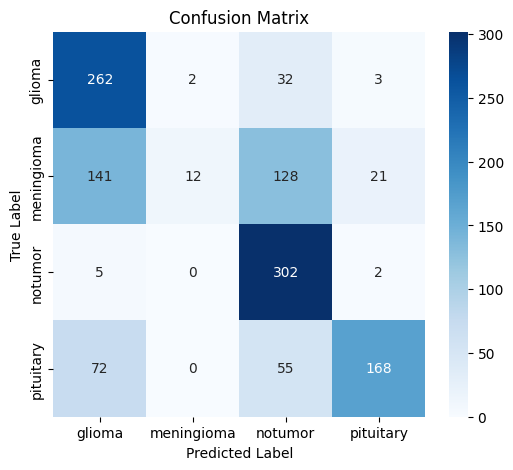

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, data_generator):
    y_true, y_pred = [], []

    for images, labels in data_generator:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
        if len(y_true) >= data_generator.samples:
            break

    class_names = list(data_generator.class_indices.keys())

    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Run evaluation
evaluate_model(model, test_data)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step


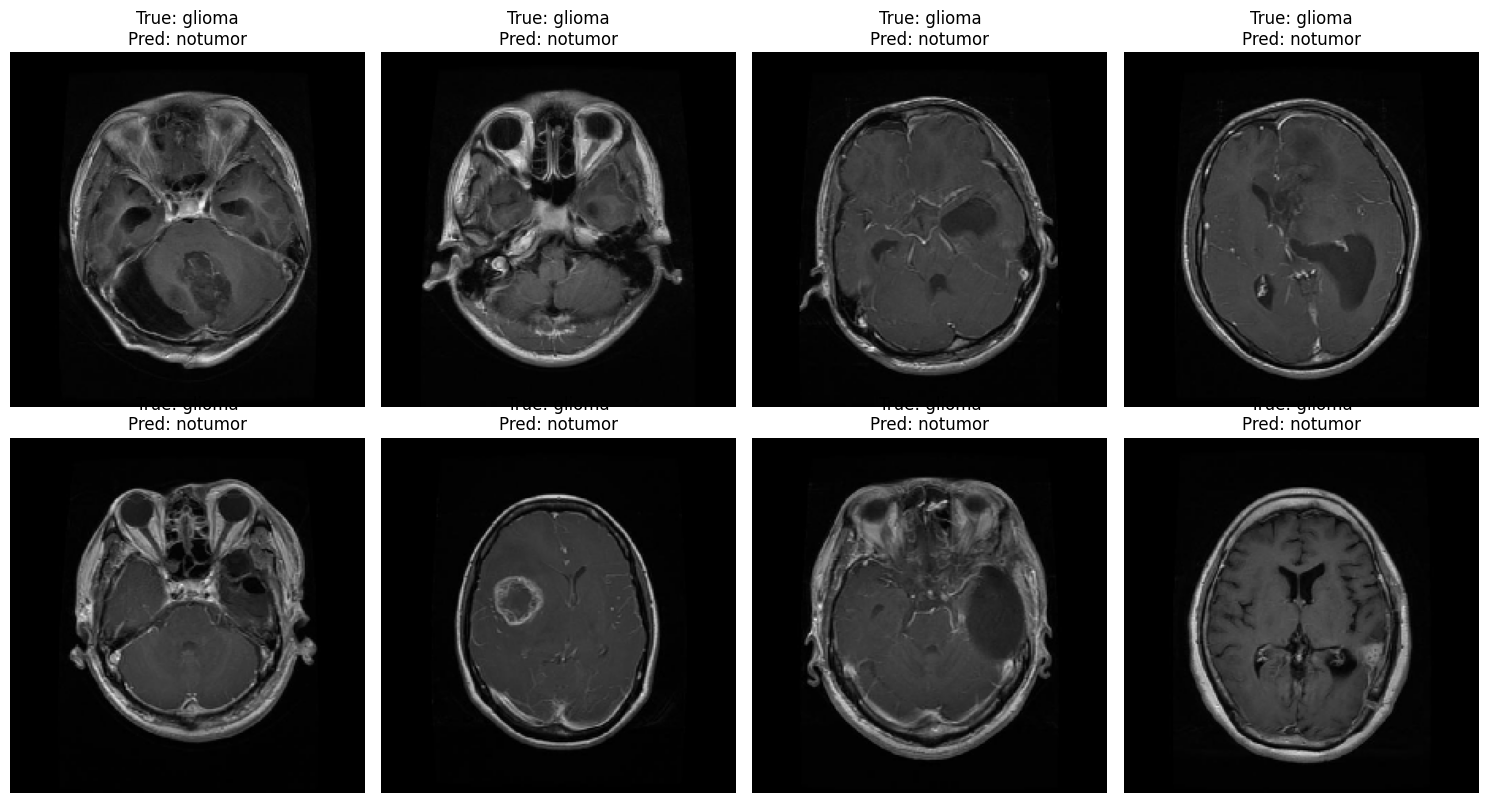

In [11]:
# Get predictions
y_pred_probs = model.predict(test_data)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = test_data.classes

# Class label mapping (adjust if needed)
class_names = list(test_data.class_indices.keys())

# Get misclassified pituitary image indices
misclassified_idx = np.where((y_true == 0) & (y_pred_classes != 0))[0]

# Optional: get image batch array
test_images = np.concatenate([test_data[i][0] for i in range(len(test_data))])

# Visualize a few misclassified images
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
for i, idx in enumerate(misclassified_idx[:8]):
    image = test_images[idx]
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred_classes[idx]]

    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [12]:
from transformers import pipeline
import numpy as np

# 1) load a simple text‐generator
generator = pipeline("text-generation", model="distilgpt2")

# 2) predict on a handful of test images
y_probs   = model.predict(test_data)
y_classes = np.argmax(y_probs, axis=1)
class_map = {v:k for k,v in test_data.class_indices.items()}

# 3) for each class (or for individual examples), prompt the model
for cls_idx in sorted(set(y_classes)):
    cls_name = class_map[cls_idx]
    prompt   = f"Generate a short radiology report summary for a {cls_name} tumor."
    summary  = generator(prompt, max_length=40, num_return_sequences=1)[0]['generated_text']
    print(f"— {cls_name} → {summary}\n")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


— glioma → Generate a short radiology report summary for a glioma tumor.




The initial phase, after the primary phase, consists of three basic steps that are described:
1

— meningioma → Generate a short radiology report summary for a meningioma tumor. (a) Radiation exposure from cancer cells, and the presence of radiators (red) and irradiation (green)

— notumor → Generate a short radiology report summary for a notumor tumor.

— pituitary → Generate a short radiology report summary for a pituitary tumor. Results presented here are based on a full review of a new and much-implemented report from the University of Chicago.



In [13]:
# save in Colab
model.save('brain_tumor_detector.h5')
